# Notebook initialization

## Selecting best GPU

In [1]:
import os
os.environ['PYTHONHASHSEED'] = '0'
import gpustat

stats = gpustat.GPUStatCollection.new_query()
ids = map(lambda gpu: int(gpu.entry['index']), stats)
ratios = map(lambda gpu: float(gpu.entry['memory.used'])/float(gpu.entry['memory.total']), stats)
bestGPU = 1#min(zip(ids, ratios), key=lambda x: x[1])[0]

print("setGPU: Setting GPU to: {}".format(bestGPU))
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = str(bestGPU)

setGPU: Setting GPU to: 1


##  Global variables

In [6]:
# IPython extension to reload modules before executing user code.
# 'autoreload' reloads modules automatically before entering the execution of code typed at the IPython prompt.
%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(0, "../")

simulation_id = 3
weights_id = 6

weights_path = lambda name: '../weights/{}/{}/'.format(weights_id, name)
figures_path = lambda name: 'figures/{}/{}/'.format(simulation_id, name)

## Seed initialization (for reproductible results)

In [3]:
# Setting the seed for NumPy generated random numbers
import numpy as np
np.random.seed(0)

# Setting the seed for Python random numbers
import random as rn
rn.seed(0)

# Setting the seed for TensorFlow random numbers
import tensorflow as tf
tf.set_random_seed(0)

from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.3
set_session(tf.Session(config=config))

Using TensorFlow backend.


# Importing weights

In [3]:
import numpy as np
import keras
import matplotlib.pyplot as plt
from collections import defaultdict
from numpy.linalg import norm
import itertools

import matplotlib
matplotlib.use('nbagg')
import matplotlib.pyplot as plt
from collections import OrderedDict
import pathlib
import pickle

Using TensorFlow backend.


In [4]:
from math import ceil, floor

In [5]:
from data_utils import *
from keras_utils import *
from models import VGG16_beta
from layca_optimizers import SGD

ImportError: No module named 'data_utils'

In [9]:
num_classes = 10

In [10]:
(x_train, y_train), (x_test, y_test) = import_cifar(num_classes)

In [11]:
# Simply loading both the initial and finals weights of our models

models = {  
    'vgg16_sgd_0':      VGG16_beta(input_shape=(32,32,3), num_classes=num_classes, weight_decay=0.0),
    'vgg16_sgd_1':      VGG16_beta(input_shape=(32,32,3), num_classes=num_classes, weight_decay=0.0),
    'vgg16_sgd_2':      VGG16_beta(input_shape=(32,32,3), num_classes=num_classes, weight_decay=0.0),
    
    'vgg16_wdecay_0':   VGG16_beta(input_shape=(32,32,3), num_classes=num_classes, weight_decay=0.001),
    'vgg16_wdecay_1':   VGG16_beta(input_shape=(32,32,3), num_classes=num_classes, weight_decay=0.001),
    'vgg16_wdecay_2':   VGG16_beta(input_shape=(32,32,3), num_classes=num_classes, weight_decay=0.001),
    
    'vgg16_layca_0':    VGG16_beta(input_shape=(32,32,3), num_classes=num_classes, weight_decay=0.0),
    'vgg16_layca_1':    VGG16_beta(input_shape=(32,32,3), num_classes=num_classes, weight_decay=0.0),
    'vgg16_layca_2':    VGG16_beta(input_shape=(32,32,3), num_classes=num_classes, weight_decay=0.0)
} 

In [12]:
for name, model in models.items():
    pathlib.Path(figures_path(name)).mkdir(parents=True, exist_ok=True)

In [13]:
for name, model in models.items():
    model.load_weights(weights_path(name) + 'final/weights-final.hdf5') 

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/linux/mnovak/penv/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 3291, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-5d7ce363d616>", line 2, in <module>
    model.load_weights(weights_path(name) + 'final/weights-final.hdf5')
  File "/linux/mnovak/penv/lib/python3.5/site-packages/keras/engine/network.py", line 1166, in load_weights
    f, self.layers, reshape=reshape)
  File "/linux/mnovak/penv/lib/python3.5/site-packages/keras/engine/saving.py", line 1038, in load_weights_from_hdf5_group
    weight_values = [np.asarray(g[weight_name]) for weight_name in weight_names]
  File "/linux/mnovak/penv/lib/python3.5/site-packages/keras/engine/saving.py", line 1038, in <listcomp>
    weight_values = [np.asarray(g[weight_name]) for weight_name in weight_names]
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.wit

KeyError: "Unable to open object (file read failed: time = Sat Aug  3 07:42:57 2019\n, filename = '../weights/6/vgg16_wdecay_0/final/weights-final.hdf5', file descriptor = 78, errno = 5, error message = 'Input/output error', buf = 0x7fafccb2ef60, total read size = 512, bytes this sub-read = 512, bytes actually read = 18446744073709551615, offset = 21178528)"

# Pruning aléatoire sur toutes les couches

In [1]:
# colors = dict(zip(['vgg16_sgd_0', 
#                     'vgg16_sgd_1', 
#                     'vgg16_sgd_2',
#                     'vgg16_wdecay_0', 
#                     'vgg16_wdecay_1', 
#                     'vgg16_wdecay_2', 
#                     'vgg16_layca_0', 
#                     'vgg16_layca_1', 
#                     'vgg16_layca_2'],
                  
#                   ['#FF8F00',
#                    '#FFB74D',
#                    '#FFCC80',
#                    '#4CAF50',
#                    '#9CCC65',
#                    '#C5E1A5',
#                    '#0D47A1',
#                    '#3F51B5',
#                    '#9FA8DA']))        

colors = dict(zip(['vgg16_sgd_0', 
                    'vgg16_sgd_1', 
                    'vgg16_sgd_2',
                    'vgg16_wdecay_0', 
                    'vgg16_wdecay_1', 
                    'vgg16_wdecay_2', 
                    'vgg16_layca_0', 
                    'vgg16_layca_1', 
                    'vgg16_layca_2'],
                  
                  ['#FF8F00',
                   '#FF8F00',
                   '#FF8F00',
                   '#4CAF50',
                   '#4CAF50',
                   '#4CAF50',
                   '#0D47A1',
                   '#0D47A1',
                   '#0D47A1'])) 

In [12]:
def evaluate(model):
    sgd = SGD(lr=0.001, momentum=0.9, nesterov=True)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    scores = model.evaluate(x_test, y_test, verbose=1)
    
    return scores[1]

In [13]:
def get_random(arr, k):
    return np.random.choice(np.arange(arr.size), replace=False, size=int(arr.size * k))

In [9]:
pruning_percentage = np.concatenate(([0], np.linspace(0.01, 0.9, 25)))

In [7]:
accuracies_random = defaultdict(list,
            {'vgg16_layca_0': [0.6488,
              0.5882,
              0.3028,
              0.2274,
              0.1255,
              0.1177,
              0.1059,
              0.0938,
              0.1,
              0.1,
              0.1,
              0.1,
              0.1,
              0.1,
              0.1,
              0.1,
              0.1,
              0.1,
              0.1,
              0.1,
              0.1,
              0.1,
              0.1,
              0.1,
              0.1,
              0.1],
             'vgg16_layca_1': [0.7404,
              0.7144,
              0.5719,
              0.2705,
              0.2192,
              0.2055,
              0.1148,
              0.1,
              0.1137,
              0.1,
              0.1,
              0.1062,
              0.1,
              0.1,
              0.1,
              0.1,
              0.1,
              0.1,
              0.1,
              0.1,
              0.1,
              0.1,
              0.1,
              0.1,
              0.1,
              0.1],
             'vgg16_layca_2': [0.8497,
              0.8516,
              0.8331,
              0.7812,
              0.694,
              0.5324,
              0.3391,
              0.1979,
              0.103,
              0.1537,
              0.1001,
              0.1,
              0.1,
              0.1,
              0.1,
              0.1,
              0.1,
              0.1,
              0.1,
              0.1,
              0.1,
              0.1,
              0.1,
              0.1,
              0.1,
              0.1],
             'vgg16_sgd_0': [0.6427,
              0.5225,
              0.2738,
              0.1088,
              0.1121,
              0.1222,
              0.1003,
              0.1,
              0.1009,
              0.0986,
              0.1,
              0.1,
              0.1,
              0.1,
              0.1,
              0.1,
              0.1,
              0.1,
              0.1,
              0.1,
              0.1,
              0.1,
              0.1,
              0.1,
              0.1,
              0.1],
             'vgg16_sgd_1': [0.7531,
              0.7206,
              0.5026,
              0.1971,
              0.2061,
              0.1442,
              0.1001,
              0.1,
              0.1,
              0.1,
              0.1,
              0.1,
              0.1,
              0.1,
              0.1,
              0.1,
              0.1,
              0.1,
              0.1,
              0.1,
              0.1,
              0.1,
              0.1,
              0.1,
              0.1,
              0.1],
             'vgg16_sgd_2': [0.8364,
              0.8308,
              0.7084,
              0.3854,
              0.2154,
              0.1648,
              0.1691,
              0.1039,
              0.1,
              0.1,
              0.1,
              0.1,
              0.1,
              0.1,
              0.1,
              0.1,
              0.1,
              0.1,
              0.1,
              0.1,
              0.1,
              0.1,
              0.1,
              0.1,
              0.1,
              0.1],
             'vgg16_wdecay_0': [0.6591,
              0.6396,
              0.3131,
              0.1742,
              0.1139,
              0.1079,
              0.1227,
              0.1015,
              0.0981,
              0.1,
              0.0979,
              0.1,
              0.1,
              0.1,
              0.1,
              0.1,
              0.1,
              0.1,
              0.1,
              0.1,
              0.1,
              0.1,
              0.1,
              0.1,
              0.1,
              0.1],
             'vgg16_wdecay_1': [0.7388,
              0.711,
              0.4356,
              0.2064,
              0.2019,
              0.1005,
              0.1,
              0.1151,
              0.1,
              0.1066,
              0.0955,
              0.1,
              0.1,
              0.1,
              0.1,
              0.1,
              0.1,
              0.1,
              0.1,
              0.1,
              0.1,
              0.1,
              0.1,
              0.1,
              0.1,
              0.1],
             'vgg16_wdecay_2': [0.864,
              0.8603,
              0.8404,
              0.7776,
              0.615,
              0.4566,
              0.2687,
              0.1438,
              0.1107,
              0.1,
              0.1,
              0.1,
              0.1,
              0.1,
              0.1,
              0.1,
              0.1,
              0.1,
              0.1,
              0.1,
              0.1,
              0.1,
              0.1,
              0.1,
              0.1,
              0.1]})

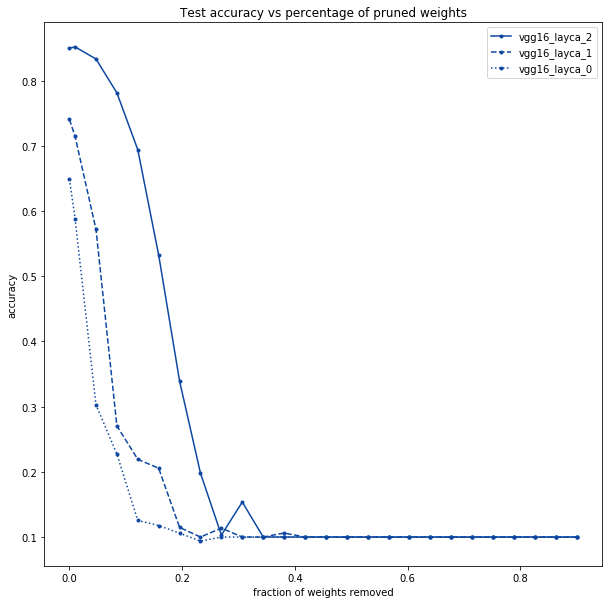

In [14]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.set(title='Test accuracy vs percentage of pruned weights', xlabel='fraction of weights removed', ylabel='accuracy')
optimiser = 'layca'


for name, style in zip(['vgg16_' + optimiser + '_2',
             'vgg16_' + optimiser + '_1', 
             'vgg16_' + optimiser + '_0'], ['-', '--', ':']):
    
    ax.plot(pruning_percentage, accuracies_random[name], linestyle=style, marker='o', markersize=3, color=colors[name], label=name)

ax.legend()

plt.show()
fig.savefig(optimiser + '_random', dpi=100)

# Pruning des plus petits poids sur toutes les couches

In [16]:
accuracies_smallest = defaultdict(list,
            {'vgg16_layca_0': [0.6488,
              0.6488,
              0.6485,
              0.6482,
              0.6482,
              0.6475,
              0.6436,
              0.639,
              0.6219,
              0.5969,
              0.5489,
              0.5148,
              0.5013,
              0.4486,
              0.3815,
              0.3419,
              0.3018,
              0.2097,
              0.1314,
              0.1122,
              0.1162,
              0.1,
              0.1,
              0.1,
              0.1,
              0.1],
             'vgg16_layca_1': [0.7404,
              0.7405,
              0.7401,
              0.7418,
              0.741,
              0.7408,
              0.738,
              0.7342,
              0.7259,
              0.7244,
              0.7089,
              0.7043,
              0.686,
              0.6679,
              0.6298,
              0.5864,
              0.5373,
              0.4571,
              0.3864,
              0.2533,
              0.1738,
              0.1642,
              0.1579,
              0.1448,
              0.1027,
              0.1],
             'vgg16_layca_2': [0.8497,
              0.8497,
              0.8495,
              0.8492,
              0.8495,
              0.8493,
              0.8494,
              0.8494,
              0.8501,
              0.8494,
              0.8503,
              0.8512,
              0.8508,
              0.8499,
              0.8493,
              0.8504,
              0.8494,
              0.8459,
              0.8416,
              0.8298,
              0.8091,
              0.7723,
              0.6953,
              0.5221,
              0.2351,
              0.1151],
             'vgg16_sgd_0': [0.6427,
              0.6427,
              0.6418,
              0.6422,
              0.6375,
              0.6356,
              0.6277,
              0.6138,
              0.5898,
              0.5634,
              0.4938,
              0.4622,
              0.4299,
              0.3431,
              0.3467,
              0.2357,
              0.2009,
              0.156,
              0.1723,
              0.1149,
              0.0996,
              0.1,
              0.1,
              0.1,
              0.1,
              0.1],
             'vgg16_sgd_1': [0.7531,
              0.7532,
              0.7531,
              0.7534,
              0.7543,
              0.7525,
              0.7469,
              0.738,
              0.7302,
              0.7242,
              0.7063,
              0.697,
              0.671,
              0.5837,
              0.4801,
              0.3397,
              0.2536,
              0.2013,
              0.1187,
              0.1263,
              0.1,
              0.1,
              0.1048,
              0.1,
              0.1,
              0.1],
             'vgg16_sgd_2': [0.8364,
              0.8363,
              0.8361,
              0.8363,
              0.836,
              0.8357,
              0.8363,
              0.8364,
              0.8349,
              0.834,
              0.832,
              0.8292,
              0.8245,
              0.8146,
              0.7881,
              0.7149,
              0.5322,
              0.4098,
              0.3475,
              0.3068,
              0.2831,
              0.2631,
              0.2096,
              0.1886,
              0.1,
              0.1],
             'vgg16_wdecay_0': [0.6591,
              0.6587,
              0.6594,
              0.6604,
              0.6567,
              0.653,
              0.6418,
              0.6267,
              0.6161,
              0.5984,
              0.5647,
              0.4678,
              0.3546,
              0.3568,
              0.2773,
              0.1991,
              0.2213,
              0.19,
              0.1679,
              0.1065,
              0.1,
              0.1,
              0.1023,
              0.1,
              0.1,
              0.1],
             'vgg16_wdecay_1': [0.7388,
              0.7387,
              0.7389,
              0.7378,
              0.737,
              0.7352,
              0.7295,
              0.7306,
              0.7224,
              0.7168,
              0.6986,
              0.6583,
              0.6213,
              0.5382,
              0.4298,
              0.3187,
              0.2482,
              0.2034,
              0.1751,
              0.1575,
              0.1224,
              0.1606,
              0.1359,
              0.1498,
              0.1,
              0.14],
             'vgg16_wdecay_2': [0.864,
              0.864,
              0.864,
              0.8641,
              0.864,
              0.8639,
              0.864,
              0.8637,
              0.8637,
              0.8634,
              0.8636,
              0.8632,
              0.8628,
              0.8632,
              0.8628,
              0.8623,
              0.8615,
              0.8605,
              0.8579,
              0.8476,
              0.7802,
              0.4516,
              0.1189,
              0.1,
              0.1,
              0.1]})

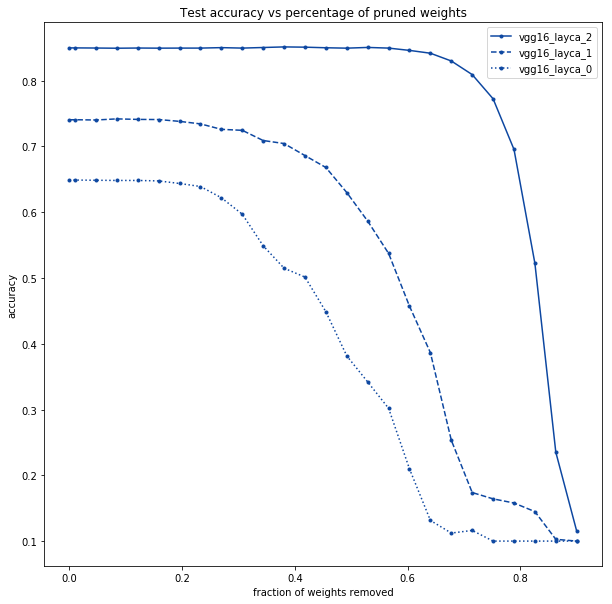

In [22]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.set(title='Test accuracy vs percentage of pruned weights', xlabel='fraction of weights removed', ylabel='accuracy')
optimiser = 'layca'


for name, style in zip(['vgg16_' + optimiser + '_2',
             'vgg16_' + optimiser + '_1', 
             'vgg16_' + optimiser + '_0'], ['-', '--', ':']):
    
    ax.plot(pruning_percentage, accuracies_smallest[name], linestyle=style, marker='o', markersize=3, color=colors[name], label=name)

ax.legend()

plt.show()
fig.savefig(optimiser + '_smallest', dpi=100)

# Pruning quelconque ciblé sur une couche

In [16]:
def pruning_accuracy(pruning_fct, layer):    
    # loading the weights of the layer
    old_weights = get_layer_weights(layer)
    
    pruning_percentage = np.concatenate(([0], np.linspace(0.01, 0.9, 18)))
    accuracies = list()
    
    # calculting the accuracy of the model when pruned by a percentage x of its weights (in the given layer)
    for x in pruning_percentage:
        new_weights = np.copy(old_weights)
        # finding the smallest weights in the layer
        indices = pruning_fct(np.abs(new_weights), floor(x*new_weights.size))
        # setting them to zero
        new_weights[indices] = 0
        set_layer_weights(layer, new_weights)
        # calculating the accuracy of this new model
        accuracies.append(evaluate(model))
        # resetting the weights for the next iteration
        set_layer_weights(layer, old_weights)    
        
    return pruning_percentage, accuracies 


# valeur absolue et pas simplement tri (la on retire les poids negatifs et cest pas ce quon veut)
# lire papier pruning
# regarder si les poids de faible amplitude et qui diminue le long du training sont moins importants au niveau pruning
# que les poids de faible amplitude qui ne convergent vers zero

# voir si on a plus de weights intermediaires dans les moins bons modeles. on imagine quun poids intermediaire est 
# nefaste 
        

In [ ]:
xs = defaultdict(list)
accs = defaultdict(list)

for name in ['vgg16_sgd_0', 'vgg16_sgd_1', 'vgg16_sgd_2', 'vgg16_wdecay_0', 'vgg16_wdecay_1', 'vgg16_wdecay_2', 'vgg16_layca_0', 'vgg16_layca_1', 'vgg16_layca_2']:
    model = models[name]
    xs[name], accs[name] = pruning_accuracy(get_indices_of_k_smallest, get_kernel_layer(model)[11])

10000/10000 [==============================] - 17s 2ms/step


In [ ]:
# preparing the plot
fig, ax = plt.subplots(figsize=(10, 10))
ax.set(title='Test accuracy vs percentage of pruned weights', xlabel='percentage', ylabel='accuracy')

for color, name in zip(['#FF8F00',
                       '#FFB74D',
                       '#FFCC80',
                       '#4CAF50',
                       '#9CCC65',
                       '#C5E1A5',
                       '#0D47A1',
                       '#3F51B5',
                       '#9FA8DA'], 
                       
                       ['vgg16_sgd_0', 
                        'vgg16_sgd_1', 
                        'vgg16_sgd_2',
                        'vgg16_wdecay_0', 
                        'vgg16_wdecay_1', 
                        'vgg16_wdecay_2', 
                        'vgg16_layca_0', 
                        'vgg16_layca_1', 
                        'vgg16_layca_2']):
    
    ax.plot(xs[name], accs[name], linestyle='--', marker='o', markersize=3, color=color, label=name)

ax.legend()

plt.show()# fig.savefig(figures_path(name), dpi=100)

pruning général
pruning sur des layers avec des rotations rate différents
pruning

In [ ]:
pseudo code

for model in models:
    for x in pruning_percentage:
        accuracy = pruning_accuracy(x, fct=random_pruning)
        sum_accuracy += accuracy

    average_accuracy = sum_accuracy/n

print(average_accuracy)